In [2]:
import os
import gc
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.layers import (Dense, InputLayer, Conv2D, MaxPooling2D, Flatten, 
                                     GlobalAveragePooling2D, Dropout)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import (SparseCategoricalCrossentropy, CategoricalCrossentropy)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
PATH_train = 'Apple/'
IMAGE_SIZE = 64
BATCH_SIZE = 32

In [5]:
data = []
label = []

class_before = np.sort(os.listdir(PATH_train))

for class_name in class_before:
    print(f'Name: {class_name}')
    for file_total in tqdm(os.listdir(PATH_train + class_name)):
        names = class_before
        names = np.where(names != class_name, 0.0, names)
        names = np.where(names == class_name, 1.0, names)
        image_file = PATH_train + class_name +'/'+ file_total
        data.append(np.asarray(Image.open(image_file).resize((IMAGE_SIZE, IMAGE_SIZE)).convert('RGB')))
        label.append(names)

Name: Apple___Apple_scab


  0%|          | 0/630 [00:00<?, ?it/s]

100%|██████████| 630/630 [00:08<00:00, 70.51it/s]


Name: Apple___Black_rot


100%|██████████| 621/621 [00:08<00:00, 72.56it/s]


Name: Apple___Cedar_apple_rust


100%|██████████| 275/275 [00:04<00:00, 59.38it/s]


Name: Apple___healthy


100%|██████████| 1645/1645 [00:26<00:00, 61.68it/s]


In [6]:
data = np.array(data, dtype='float32') / 255
label = np.array(label, dtype='float32')

In [7]:
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

In [8]:
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size = 1 - train_ratio, random_state=123)

In [9]:
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio / (test_ratio + validation_ratio), random_state=123)

In [10]:
print(f'Data: {np.shape(data)}')
print(f'Label: {np.shape(label)}')
print(f'x_train: {np.shape(x_train)}')
print(f'y_train: {np.shape(y_train)}')
print(f'x_val: {np.shape(x_val)}')
print(f'y_val: {np.shape(y_val)}')
print(f'x_test: {np.shape(x_test)}')
print(f'y_test: {np.shape(y_test)}')

Data: (3171, 64, 64, 3)
Label: (3171, 4)
x_train: (2536, 64, 64, 3)
y_train: (2536, 4)
x_val: (317, 64, 64, 3)
y_val: (317, 4)
x_test: (318, 64, 64, 3)
y_test: (318, 4)


In [11]:
datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        shear_range = 10
)

<class 'numpy.ndarray'>


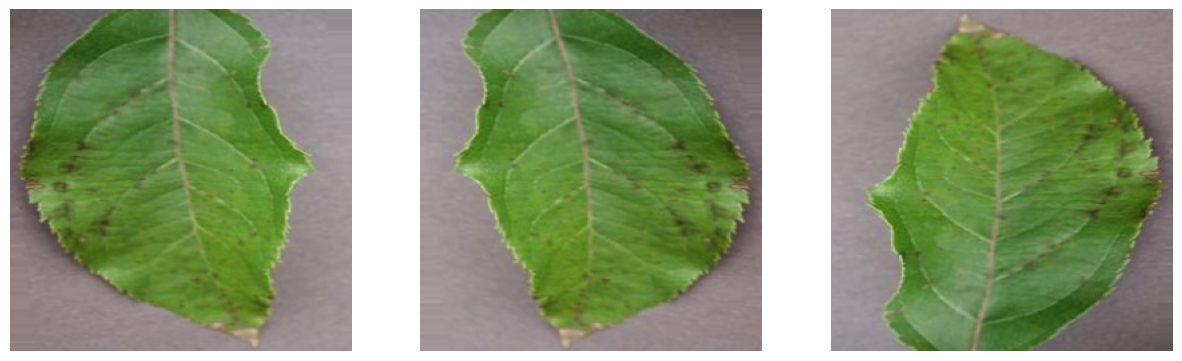

In [14]:
img = io.imread("Apple\Apple___Apple_scab\\0a5e9323-dbad-432d-ac58-d291718345d9___FREC_Scab 3417.JPG")
img = img.reshape((1, ) + img.shape)

print(type(img))
aug_iter = datagen.flow(img, batch_size=1)

fig, ax = plt.subplots(1, 3, figsize=(15,15))

# generate batch of images
for i in range(3):
    # convert to unsigned integers
    image = next(aug_iter)[0].astype('uint8')
    
    # plot image
    ax[i].imshow(image)
    ax[i].axis('off')

In [15]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= 0.9:
            self.model.stop_training = True

callbacks = CustomCallback()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=0.0001)
early_stopping = EarlyStopping(patience=20, monitor='val_accuracy', restore_best_weights=True)

In [16]:
def create_model():
    model = Sequential([
        Conv2D(64, 3, activation='relu', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        MaxPooling2D(2, 2),
        Conv2D(32, 3, activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        GlobalAveragePooling2D(),
        Dense(64, activation='relu'),
        Dense(y_train.shape[1], activation='softmax')
    ])

    model.compile(loss=CategoricalCrossentropy(),
              optimizer=Adam(0.001),
              metrics=['accuracy'])

    return model

In [17]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 global_average_pooling2d (  (None, 32)                0         
 GlobalAveragePooling2D)                                         
                                                        

In [18]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE), 
                    validation_data = (x_val, y_val),
                    epochs=200,
                    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
                    callbacks=[early_stopping])

Epoch 1/200
79/79 [==============================] - 21s 253ms/step - loss: 1.2150 - accuracy: 0.5052 - val_loss: 1.1328 - val_accuracy: 0.5489
Epoch 2/200
79/79 [==============================] - 20s 246ms/step - loss: 1.0999 - accuracy: 0.5216 - val_loss: 0.9676 - val_accuracy: 0.5868
Epoch 3/200
79/79 [==============================] - 15s 191ms/step - loss: 0.9512 - accuracy: 0.5899 - val_loss: 0.8410 - val_accuracy: 0.5994
Epoch 4/200
79/79 [==============================] - 15s 186ms/step - loss: 0.8581 - accuracy: 0.6466 - val_loss: 0.7638 - val_accuracy: 0.6972
Epoch 5/200
79/79 [==============================] - 14s 181ms/step - loss: 0.7295 - accuracy: 0.7097 - val_loss: 0.6756 - val_accuracy: 0.7224
Epoch 6/200
79/79 [==============================] - 15s 193ms/step - loss: 0.7003 - accuracy: 0.7220 - val_loss: 0.6513 - val_accuracy: 0.7413
Epoch 7/200
79/79 [==============================] - 18s 236ms/step - loss: 0.6668 - accuracy: 0.7185 - val_loss: 0.7087 - val_accuracy:

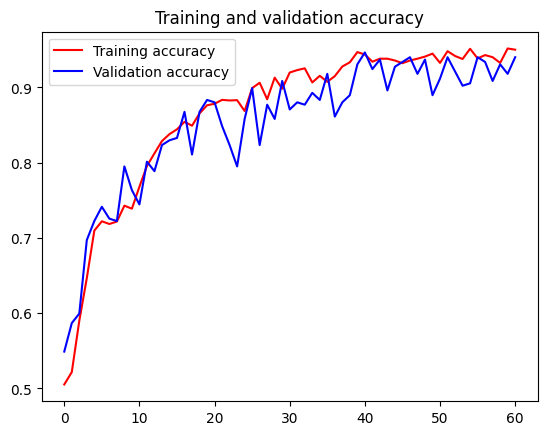

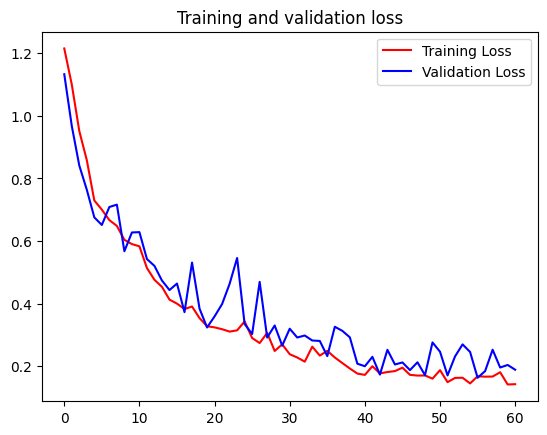

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
# target = (y_pred > 0.5).astype(np.float32)
print(classification_report(y_true, y_pred, target_names=class_before))

10/10 [==============================] - 1s 41ms/step
                          precision    recall  f1-score   support

      Apple___Apple_scab       0.89      0.71      0.79        55
       Apple___Black_rot       0.89      0.99      0.94        67
Apple___Cedar_apple_rust       0.86      0.96      0.91        26
         Apple___healthy       0.95      0.95      0.95       170

                accuracy                           0.92       318
               macro avg       0.90      0.90      0.90       318
            weighted avg       0.92      0.92      0.92       318

